k-Means algorithm for clustering on the sporulation data set.

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from itertools import permutations

Load the yeast sporulation dataset

In [42]:
# Load the sporulation dataset
df = pd.read_csv('sporulation-filtered.txt', sep='\t')

# Drop the 'Genes' column, as KMeans only works with numerical data
X = df.drop(columns=['Genes'])

# Convert the values from string to float
# Replace ',' with '.' so that the values can be converted to float
X.replace({',': '.'}, regex=True, inplace=True)
X = X.iloc[:-2,:]
X = X.astype(float)

# Create a list of gene data without one of the time steps
# t0 t0,5 t2 t5 t7 t9 t11,5
X_without_time_step = [X.drop(columns=['t0']), 
                       X.drop(columns=['t0,5']), 
                       X.drop(columns=['t2']), 
                       X.drop(columns=['t5']), 
                       X.drop(columns=['t7']), 
                       X.drop(columns=['t9']), 
                       X.drop(columns=['t11,5'])]
    
X.tail()

,t0,"t0,5",t2,t5,t7,t9,"t11,5"
469,1.473570,-0.980588,0.187547,-0.775976,-1.067287,0.126038,1.036696
470,1.543327,-1.090000,-0.374713,-0.780946,-0.671057,0.308319,1.065071
471,1.855230,-0.550056,-0.264951,-1.042622,-0.729874,-0.019525,0.751798
472,1.785611,-0.406223,-0.895333,-0.585125,-0.816870,0.003997,0.913943
473,1.552631,-0.019515,-0.392120,-1.218152,-0.896972,-0.092712,1.066840


In [43]:
# Number of clusters
clusters = 7
# number of Time dimensions
l = 7
# Number of genes
M = 474

use the K-means algorithm

In [44]:
# Use the KMeans algorithm to cluster the data
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

y_kmeans_without = [0 for i in range(l)]
for i in range(len(X_without_time_step)):
    kmeans_without = KMeans(n_clusters=7)
    kmeans_without.fit(X_without_time_step[i])
    y_kmeans_without[i] = kmeans_without.predict(X_without_time_step[i])

len(y_kmeans)

474

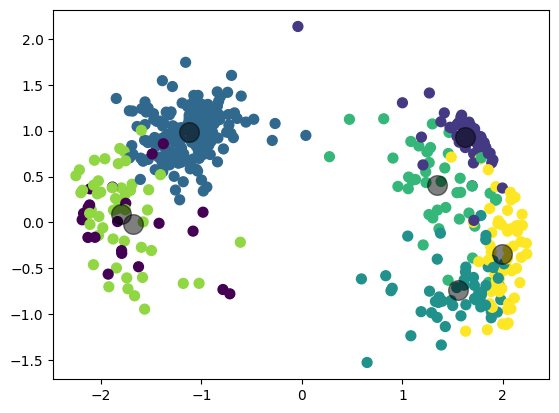

In [45]:
# Plot the clusters
dim1, dim2 = 0, 6
plt.scatter(X.iloc[:, dim1], X.iloc[:, dim2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, dim1], centers[:, dim2], c='black', s=200, alpha=0.5)

plt.show()

Do the K-means with a skip 

In [46]:
# Calculate the average proportion of non-overlap measure
# V1(K) = 1/(M*l) * sum_{g=1}^{M}(sum_{i=1}^{l}(1-n(C_g,i intersection C_g,0)/(n*C_g,0))
# K = 7 is the number of classes we set a clustering algorithm to produce
# l = 7 is the number of dims
# M = 274 is the number of genes
# C_g,i denote the cluster containing gene g in the clustering based on the data set with time Ti observations deleted.

average_proportion_non_overlap = 0
for g in range(M):
    # Get the original elements of a cluster containing gene g
    cluster_g_0 = (y_kmeans == y_kmeans[g])
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (y_kmeans_without[i] == y_kmeans_without[i][g])

        # Calculate the proportion of non-overlap
        intersection_of_Cs = sum([a and b for a, b in zip(cluster_g_0, cluster_g_i)])

        average_proportion_non_overlap += 1/(M*l) * (1 - intersection_of_Cs/(sum(cluster_g_0)))
average_proportion_non_overlap

np.float64(0.2376444277484676)

In [47]:
# The average distance between means measure between means
# V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))
average_distance_between_means = 0

# means_g_is = [[0]*clusters]*l
# for i in l:
#     for cluster in clusters:
#         means_g_is[i][cluster] = np.mean(X_without_time_step[i].iloc[(y_kmeans_without[i] == y_kmeans_without[i][cluster]), :])
for g in range(M):
    cluster_g_0 = (y_kmeans == y_kmeans[g])
    mean_g_0 = np.mean(X.iloc[cluster_g_0])
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (y_kmeans_without[i] == y_kmeans_without[i][g])
        mean_g_i = np.mean(X_without_time_step[i].iloc[cluster_g_i])
        average_distance_between_means += 1/(M*l) * abs(mean_g_0 - mean_g_i)
average_distance_between_means

np.float64(0.11823727974715752)

In [53]:
# The average distance between means measure between means
# V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))
average_distance_between_means = 0

for g in range(M):
    cluster_g_0 = (y_kmeans == y_kmeans[g])
    C_g_0 = X.iloc[cluster_g_0]
    mean_C_g_0 = [0 for i in range(l)]
    for i in range(l):
        mean_C_g_0[i] = np.mean(C_g_0.iloc[:, i])

    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (y_kmeans_without[i] == y_kmeans_without[i][g])
        C_g_i = X.iloc[cluster_g_i]
        mean_C_g_i = [0 for i in range(l)]
        for j in range(l):
            mean_C_g_i[j] = np.mean(C_g_i.iloc[:, j])
        average_distance_between_means += 1/(M*l) * euclidean(mean_C_g_0, mean_C_g_i)
average_distance_between_means

0.37172833068661054

In [55]:
# The average distance measure
# V3(K) = 1/Ml*sum_g=1..M (sum_i=1..l(1/(n(C_g,i)n(C_g,0))*sum_{g' element of C_g,i, g element of C_g,0}d(x_g,x_g')))
average_distance_measure = 0
for g in range(M):
    cluster_g_0 = (y_kmeans == y_kmeans[g])
    n_C_g_0 = sum(cluster_g_0)
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (y_kmeans_without[i] == y_kmeans_without[i][g])
        n_C_G_i = sum(cluster_g_i)

        # Calculate the sum of distances d(x_g, x_g') for genes in the same cluster in both full and reduced datasets
        distance_sum = 0
        for g_prime in range(M):
            if cluster_g_i[g_prime]:
                # Compute the distance between the expression profiles of gene g and g'
                distance_sum += euclidean(X.iloc[g, :], X.iloc[g_prime, :])  # Use Euclidean distance, but can use another metric

        # Add to the average distance measure formula
        average_distance_measure += (1 / (M * l)) * (1 / (n_C_g_0 * n_C_G_i)) * distance_sum
average_distance_measure

np.float64(0.018777776913356727)